<a href="https://colab.research.google.com/github/mcallicotte/CSCE489_HW3/blob/main/Callicotte_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#HW3

By: Mary Callicotte

###Step 0
Set-up variables

In [ ]:
SEED = 300922 # Sets the random seed for the notebook
FILEPATH = "/content/drive/MyDrive/!Data" # path to the data files in my Google Drive

LEARNING_RATE = 0.001
BATCH_SIZE = 32
N_EPOCHS = 5

IMG_SIZE = 28
N_CLASSES = 26

## Task 1

Create a dataset class suitable for loading the HW3 dataset files

### Step 1.1

Mount Google Drive to upload files to Notebook

In [ ]:
# Step 1.1

from google.colab import drive
drive.mount('/content/drive')

# ---- Testing ---- #
!ls "/content/drive/MyDrive/!Data"
# ----   END   ---- #

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
hw3-letters-test-images-idx3-ubyte  hw3-letters-train-images-idx3-ubyte
hw3-letters-test-labels-idx1-ubyte  hw3-letters-train-labels-idx1-ubyte


###Step 1.2
Create child of torch.utils.data.Dataset

In [ ]:
# Step 1.2

import torch
import numpy as np

class MyDataSet(torch.utils.data.Dataset):
  """Child of pytorch Dataset class to use pytorch dataloader on unique data"""
  def __init__(self, labelsFilepath, imagesFilepath):
    self.labelFile = labelsFilepath
    self.imageFile = imagesFilepath
    self.imageList = [] # appending to list more effiecent than np array
    self.labelList = []

    with open(labelsFilepath, 'rb') as f:
      self.labelNumber = int.from_bytes(f.read(4), byteorder = 'big')
      for i in range(0, self.labelNumber):
        self.labelList.append(ord(f.read(1)) - 1) #changes class indices from 1-26 to 0-25
    
    with open(imagesFilepath, 'rb') as f:
      self.imageNumber = int.from_bytes(f.read(4), byteorder = 'big')
      if self.imageNumber != self.labelNumber:
        raise Exception("Label and Image Numbers Did Not Match")
      self.imageRows = int.from_bytes(f.read(4), byteorder = 'big')
      self.imageCols = int.from_bytes(f.read(4), byteorder = 'big')

      for i in range(0, self.imageNumber*self.imageRows*self.imageCols):
        self.imageList.append(ord(f.read(1)))
      
    self.imageArray = np.array(self.imageList).astype(np.float32).reshape(self.imageNumber, self.imageRows, self.imageCols)
    self.labelArray = np.array(self.labelList)

    for i in range(0, self.imageNumber):
        self.imageArray[i] = self.imageArray[i].transpose()

  def len(self):
    return self.labelNumber
  
  def __len__(self):
    return self.imageNumber

  def __getitem__(self, idx):
    return (self.imageArray[idx].reshape(1, self.imageRows, self.imageCols), self.labelArray[idx])

# # ---- Testing ---- #
# testData = MyDataSet(FILEPATH + "/hw3-letters-test-labels-idx1-ubyte", FILEPATH + "/hw3-letters-test-images-idx3-ubyte")
# print(testData.len())
# print(testData.getitem(0))
# # ----   END   ---- #

###Step 1.3
Load the Datasets

In [ ]:
# Step 1.3
# requires step 0, 1.1, 1.2

trainSet = MyDataSet(FILEPATH + "/hw3-letters-train-labels-idx1-ubyte", FILEPATH + "/hw3-letters-train-images-idx3-ubyte")
testSet = MyDataSet(FILEPATH + "/hw3-letters-test-labels-idx1-ubyte", FILEPATH + "/hw3-letters-test-images-idx3-ubyte")

# # ---- Testing ---- #
# print("trainSet length =", trainSet.len(), "\ntestSet length =", testSet.len())
# print(testSet.labelList)
# # ----   END   ---- #

##Task 2
Use matplot to plot at least 20 images

Text(0.5, 0.98, 'Data Preview')

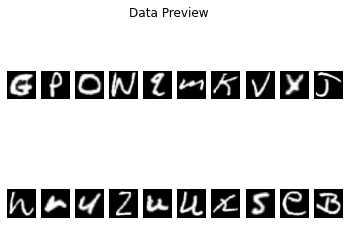

In [ ]:
# Task 2
# requires step 1.3
import matplotlib.pyplot as plt

IMG_ROWS = 10
ROW_NUM = 2

fig = plt.figure()
for i in range (1, IMG_ROWS * ROW_NUM + 1):
  plt.subplot(ROW_NUM, IMG_ROWS, i)
  plt.axis('off')
  plt.imshow(trainSet.imageArray[i], cmap = 'gray')
fig.suptitle("Data Preview")


##Task 3
Train a neural network to recognize 26 letters

###Step 3.1
Helper fucntions to help train the model

In [ ]:
#Step 3.1

from datetime import datetime

import torch 

def getAccuracy(model, dataLoader, device):
  correct_pred = 0
  n = 0

  with torch.no_grad():
    model.eval()
    for X, y_true in dataLoader:
      X = X.to(device)
      y_true = y_true.to(device)
      _, y_prob = model(X)
      _, predicted_labels = torch.max(y_prob, 1)

      n += y_true.size(0)
      correct_pred += (predicted_labels == y_true).sum()
      y_true = y_true.to('cpu')

  return correct_pred.float() / n

def plotLosses(trainLosses, validLosses):
  plt.style.use('seaborn')

  trainLosses = np.array(trainLosses)
  validLosses = np.array(validLosses)

  fig, ax = plt.subplots(figsize = (8, 4.5))

  ax.plot(trainLosses, color = 'blue', label='Training Loss')
  ax.plot(validLosses, color = 'red', label = 'Validation Loss')
  ax.set(title = "Loss over epochs", xlabel = "Epoch", ylabel = "Loss")
  ax.legend()
  fig.show()

  plt.style.use('default')

def train(trainLoader, model, criterion, optimizer, device):
  model.train()
  runningLoss = 0

  for X, y_true in trainLoader:
    optimizer.zero_grad()

    X = X.to(device)
    y_true = y_true.to(device)

    y_hat, _ = model(X)
    loss = criterion(y_hat, y_true)
    runningLoss += loss.item() * X.size(0)

    loss.backward()
    optimizer.step()

  epochLoss = runningLoss / len(trainLoader.dataset)
  return model, optimizer, epochLoss

def validate(validLoader, model, criterion, device):
  model.eval()
  runningLoss = 0

  for X, y_true in validLoader:
    X = X.to(device)
    y_true = y_true.to(device)

    y_hat, _ = model(X)
    loss = criterion(y_hat, y_true)
    runningLoss += loss.item() * X.size(0)

  epochLoss = runningLoss / len(validLoader.dataset)
  return model, epochLoss

def trainingLoop(model, criterion, optimizer, trainLoader, validLoader, epochs, device, print_every=1):
  best_loss = 1e10
  trainLosses = []
  validLosses = []

  for epoch in range(0, epochs):
    model, optimizer, trainLoss = train(trainLoader, model, criterion, optimizer, device)
    trainLosses.append(trainLoss)

    with torch.no_grad():
      model, validLoss = validate(validLoader, model, criterion, device)
      validLosses.append(validLoss)

    if epoch % print_every == (print_every - 1):
      trainAccuracy = getAccuracy(model, trainLoader, device = device)
      validAccuracy = getAccuracy(model, validLoader, device = device)

      print(f'{datetime.now().time().replace(microsecond=0)} ---' f'Epoch: {epoch}\t' 
            f'Train loss: {trainLoss:.4f}\t' f'Valid loss: {validLoss:.4f}\t' 
            f'Train accuracy: {100 * trainAccuracy:.2f}\t' f'Valid accuracy: {100 * validAccuracy:.2f}\t')
      
  plotLosses(trainLosses, validLosses)
  return model, optimizer, (trainLosses, validLosses)

###Step 3.2
Put data into the dataloaders

In [ ]:
# Step 3.2
# requires Step 1.3

from torch.utils.data import DataLoader
import torch
torch.manual_seed(SEED)

trainLoader = DataLoader(dataset = trainSet, batch_size = BATCH_SIZE, shuffle = True, generator = torch.manual_seed(SEED))
validLoader = DataLoader(dataset = testSet, batch_size = BATCH_SIZE, shuffle = True, generator = torch.manual_seed(SEED))

# # ---- Testing ---- #
# print(len(trainSet))
# print(len(testSet))

# print(len(trainLoader))
# print(len(validLoader))
# # ----   END   ---- #

###Step 3.3
Create the model as a derived class of torch.nn

In [ ]:
# Step 3.3

import torch.nn as nn
import torch.nn.functional as F

class MyNN(nn.Module):
  def __init__(self, n_classes):
    super(MyNN, self).__init__()

    self.feature_extractor = nn.Sequential(
        nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 9, stride = 1),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size = 2),
        nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 1, stride = 1),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size = 2),
        nn.Conv2d(in_channels = 16, out_channels = 120, kernel_size = 5, stride = 1),
        nn.Tanh()
    )

    self.classifier = nn.Sequential(
        nn.Linear(in_features = 120, out_features = 84), 
        nn.Tanh(),
        nn.Linear(in_features = 84, out_features = n_classes),
    )

  def forward(self, x):
    x = self.feature_extractor(x)
    x = torch.flatten(x, 1)
    logits = self.classifier(x)
    probs = F.softmax(logits, dim = 1)
    return logits, probs

###Step 3.4
Check for GPU

In [ ]:
# Step 3.4 
import torch

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda


###Step 3.5
Train the network

02:49:14 ---Epoch: 0	Train loss: 0.5894	Valid loss: 0.3740	Train accuracy: 88.87	Valid accuracy: 88.15	
02:49:30 ---Epoch: 1	Train loss: 0.3160	Valid loss: 0.3064	Train accuracy: 91.07	Valid accuracy: 90.19	
02:49:48 ---Epoch: 2	Train loss: 0.2728	Valid loss: 0.2861	Train accuracy: 91.90	Valid accuracy: 90.87	
02:50:04 ---Epoch: 3	Train loss: 0.2515	Valid loss: 0.2835	Train accuracy: 92.02	Valid accuracy: 90.91	
02:50:22 ---Epoch: 4	Train loss: 0.2338	Valid loss: 0.2731	Train accuracy: 92.54	Valid accuracy: 91.28	


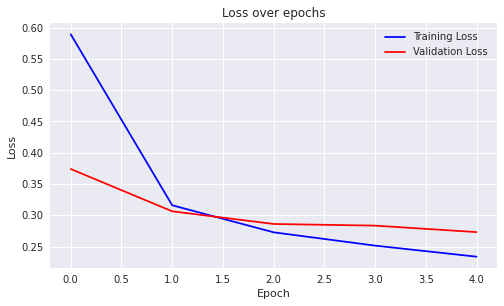

In [ ]:
# Step 3.5
# requires step 0, 3.1, 3.2, 3.3, 3.4

model = MyNN(26).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

model, optimizer, _ = trainingLoop(model, criterion, optimizer, trainLoader, validLoader, N_EPOCHS, DEVICE)

##Task 4
Compare time to train model with and without hardware accelerators

### With Hareware Accelerator
23:00:04 ---Epoch: 0	Train loss: 0.5625	Valid loss: 0.3501	Train accuracy: 89.61	Valid accuracy: 89.07	
23:00:21 ---Epoch: 1	Train loss: 0.3117	Valid loss: 0.3248	Train accuracy: 90.67	Valid accuracy: 89.75	
23:00:38 ---Epoch: 2	Train loss: 0.2750	Valid loss: 0.2886	Train accuracy: 91.91	Valid accuracy: 90.85	
23:00:54 ---Epoch: 3	Train loss: 0.2532	Valid loss: 0.2702	Train accuracy: 92.56	Valid accuracy: 91.29	
23:01:11 ---Epoch: 4	Train loss: 0.2346	Valid loss: 0.2741	Train accuracy: 92.91	Valid accuracy: 91.33	

Total Time: 1 min 7 sec

###Without Hardware Accelerator

23:15:11 ---Epoch: 0	Train loss: 0.5875	Valid loss: 0.3804	Train accuracy: 88.50	Valid accuracy: 87.85	
23:15:46 ---Epoch: 1	Train loss: 0.3138	Valid loss: 0.3071	Train accuracy: 91.13	Valid accuracy: 90.11	
23:16:22 ---Epoch: 2	Train loss: 0.2733	Valid loss: 0.2916	Train accuracy: 91.69	Valid accuracy: 90.45	
23:17:00 ---Epoch: 3	Train loss: 0.2526	Valid loss: 0.2994	Train accuracy: 91.59	Valid accuracy: 90.50	
23:17:36 ---Epoch: 4	Train loss: 0.2366	Valid loss: 0.2770	Train accuracy: 92.62	Valid accuracy: 91.09	

Total Time: 3 min 3 sec

##Task 5
Print out confusion matrix

In [ ]:
# Task 5
# requires step 3.5
import string

confusionMatrix = [[0 for i in range(27)] for j in range(27)]

count = 0
badCount = 0

colLabel = 1
for letter in string.ascii_uppercase:
  confusionMatrix[0][colLabel] =  "   " + letter
  colLabel += 1

rowLabel = 1
for letter in string.ascii_uppercase:
  confusionMatrix[rowLabel][0] = letter
  rowLabel += 1


for i in range(len(testSet)):
  count += 1
  with torch.no_grad():
    model.eval()
    y_hat, probs = model(torch.from_numpy(testSet.__getitem__(i)[0]).reshape(-1, 1, 28, 28).to(DEVICE))

  guess = f'{torch.argmax(probs)}'
  actual = f'{testSet.__getitem__(i)[1]}'

  confusionMatrix[int(actual) + 1 ][int(guess) + 1] += 1
  if (int(actual) != int(guess)):
    badCount += 1

print(str((count - badCount * 100) / (count)) + '% Accuracy\n')

print('Confusion Matrix')
print()
print('\n'.join([''.join(['{:4}'.format(item) for item in row]) for row in confusionMatrix]))


-7.721153846153846% Accuracy

Confusion Matrix

   0   A   B   C   D   E   F   G   H   I   J   K   L   M   N   O   P   Q   R   S   T   U   V   W   X   Y   Z
A    753   2   2   2   3   1   9   4   0   1   2   0   0   1   2   0   8   2   0   0   1   0   0   2   0   5
B      4 753   0   1   1   0   9  11   0   2   0   4   0   1   4   0   0   2   1   0   0   0   0   1   0   6
C      1   2 761   1  17   0   5   0   0   0   0   3   0   0   1   0   0   3   1   2   0   0   1   0   0   2
D     10   5   1 735   0   0   3   1   0   3   0   0   0   1  33   5   1   0   1   1   0   0   0   0   0   0
E      8   2  16   0 750   6   1   0   0   0   3   5   0   0   1   1   2   3   0   0   1   0   0   0   0   1
F      0   0   0   0   2 765   1   0   3   0   0   0   0   0   0   5   4   3   4  12   0   0   0   0   0   1
G     24  14   4   2   4   4 605   3   0   4   0   0   0   1   0   0 118   2   9   0   0   0   0   3   2   1
H     15   1   0   0   0   1   0 739   1   0   7  10   2  17   0   0   0   1   0